In [ ]:
import numpy as np
import os
from glob import glob
import cv2
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms

## Images

In [1]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


## Human Face Detector

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# returns true if a face is detected
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

## Dog Detector

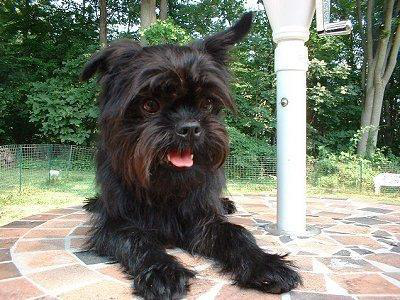

In [6]:
img_path = '/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg'
dog_image = Image.open(img_path)
dog_image

In [ ]:
VGG16 = models.vgg16(pretrained=True)
use_cuda = torch.cuda.is_available()
# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    transform = transforms.Compose([transforms.Resize(224), 
                                    transforms.CenterCrop(224), 
                                    transforms.ToTensor()])
    img = Image.open(img_path)
    img = transform(img).float()
    img = img.unsqueeze(0)
    
    if use_cuda:
        img = img.cuda()
        
    predictions = VGG16(img)
    _, index = predictions.max(1)
    
    return index.item() # predicted class index

In [8]:
# returns true if a dog is detected 
def dog_detector(img_path):
    ## TODO: Complete the function.
    index = VGG16_predict(img_path)
    
    # Categories in imageNet corresponding with dogs are keys 151 - 268
    return index > 151 and index < 268

dog_detector(img_path)

True

## Loading and transforming images

In [7]:
use_cuda = torch.cuda.is_available()
torch.cuda.empty_cache()

batch_size = 20

train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize(250),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

train_data = datasets.ImageFolder('/data/dog_images/train/', transform=train_transforms)
valid_data = datasets.ImageFolder('/data/dog_images/valid/', transform=test_transforms)
test_data = datasets.ImageFolder('/data/dog_images/test/', transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

## Model training + validation

In [9]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
                
                loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))   
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    return model

## Model testing

In [10]:
def test(model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# Self Defined CNN

In [15]:
n_breeds = 133

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) #16x224x224
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) #32x112x112
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) #64x56x56
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1) #128x28x28
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1) #256x14x14
        
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, n_breeds)
    
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
    
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.batchnorm5 = nn.BatchNorm2d(256)
        self.batchnormfc1 = nn.BatchNorm1d(1024)

    def forward(self, x):
        x = self.batchnorm1(self.pool(F.relu(self.conv1(x))))
        x = self.batchnorm2(self.pool(F.relu(self.conv2(x))))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.batchnorm4(self.pool(F.relu(self.conv4(x))))
        x = self.batchnorm5(self.pool(F.relu(self.conv5(x))))
        x = x.view(-1, 256 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [17]:
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

model_scratch = train(12, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

test(model_scratch, criterion_scratch, use_cuda)

Epoch: 1 	Training Loss: 4.605430 	Validation Loss: 4.488824
Validation loss decreased (inf --> 4.488824).  Saving model ...
Epoch: 2 	Training Loss: 4.438825 	Validation Loss: 4.433095
Validation loss decreased (4.488824 --> 4.433095).  Saving model ...
Epoch: 3 	Training Loss: 4.319245 	Validation Loss: 4.265477
Validation loss decreased (4.433095 --> 4.265477).  Saving model ...
Epoch: 4 	Training Loss: 4.202400 	Validation Loss: 4.293357
Epoch: 5 	Training Loss: 4.128904 	Validation Loss: 4.208241
Validation loss decreased (4.265477 --> 4.208241).  Saving model ...
Epoch: 6 	Training Loss: 4.031443 	Validation Loss: 4.271172
Epoch: 7 	Training Loss: 3.952779 	Validation Loss: 4.066093
Validation loss decreased (4.208241 --> 4.066093).  Saving model ...
Epoch: 8 	Training Loss: 3.862629 	Validation Loss: 4.034325
Validation loss decreased (4.066093 --> 4.034325).  Saving model ...
Epoch: 9 	Training Loss: 3.758053 	Validation Loss: 4.078770
Epoch: 10 	Training Loss: 3.665145 	Valida

# Tranfer Learning, using Resnet50 - accuracy increased by 72%

In [29]:
import torchvision.models as models
import torch.nn as nn
   
model_transfer = models.resnet50(pretrained=True)
model_transfer.fc = nn.Linear(in_features=2048, out_features=133, bias=True)

# Freeze training for CNN layers
for param in model_transfer.parameters():
    param.requires_grad = False

# Unfreeze training for fully connected (fc) layers   
for param in model_transfer.fc.parameters():
    param.requires_grad = True
    
if use_cuda:
    model_transfer = model_transfer.cuda()

In [41]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
#optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.005, momentum=0.9)

model_transfer = train(10, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

test(model_transfer, criterion_transfer, use_cuda)

Epoch: 1 	Training Loss: 0.664123 	Validation Loss: 0.574742
Validation loss decreased (inf --> 0.574742).  Saving model ...
Epoch: 2 	Training Loss: 0.638078 	Validation Loss: 0.553835
Validation loss decreased (0.574742 --> 0.553835).  Saving model ...
Epoch: 3 	Training Loss: 0.622258 	Validation Loss: 0.547497
Validation loss decreased (0.553835 --> 0.547497).  Saving model ...
Epoch: 4 	Training Loss: 0.580172 	Validation Loss: 0.541297
Validation loss decreased (0.547497 --> 0.541297).  Saving model ...
Epoch: 5 	Training Loss: 0.554721 	Validation Loss: 0.547665
Epoch: 6 	Training Loss: 0.551453 	Validation Loss: 0.533697
Validation loss decreased (0.541297 --> 0.533697).  Saving model ...
Epoch: 7 	Training Loss: 0.536834 	Validation Loss: 0.549615
Epoch: 8 	Training Loss: 0.525684 	Validation Loss: 0.591585
Epoch: 9 	Training Loss: 0.494733 	Validation Loss: 0.558215
Epoch: 10 	Training Loss: 0.480224 	Validation Loss: 0.566730
Test Loss: 0.515594


Test Accuracy: 84% (703/836

## Breed prediction function, using transfer model

In [32]:
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    # loading the image and returning the predicted breed
    img = Image.open(img_path)
    
    transform = transforms.Compose([transforms.Resize(250),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5],
                                                         [0.5, 0.5, 0.5])])
    
    img_tensor = transform(img).unsqueeze_(0)
    
    if use_cuda:
        img_tensor = img_tensor.cuda()
        
    model_transfer.eval()
    
    with torch.no_grad():
        output = model_transfer(img_tensor)
        prediction = output.data.max(1, keepdim=True)[1]
        
    model_transfer.train()
    
    breed = class_names[prediction]
    
    return breed


In [33]:
predict_breed_transfer('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')

'Affenpinscher'

## How app would run

In [48]:
def run_app(img_path):
    
    if face_detector(img_path):
        dog_breed = predict_breed_transfer(img_path)
        title_message = "You're human but you look like a " + dog_breed
        
    elif dog_detector(img_path):
        dog_breed = predict_breed_transfer(img_path)
        title_message = 'This dog = ' + dog_breed  
    
    else:
        title_message = 'error'
    
    plt.figure()
    plt.imshow(Image.open(img_path))
    plt.title(title_message)
    plt.show() 

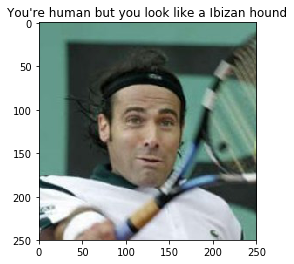

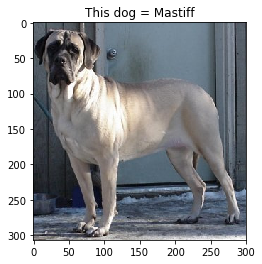

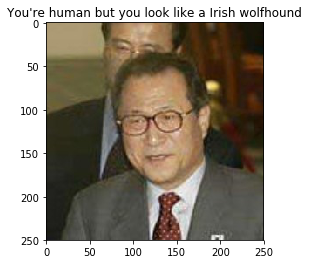

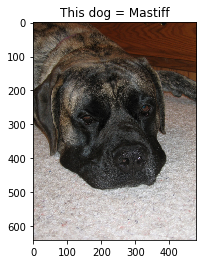

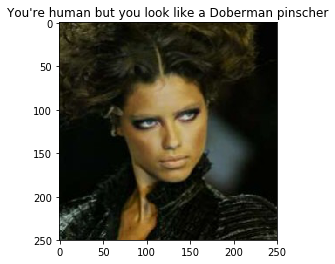

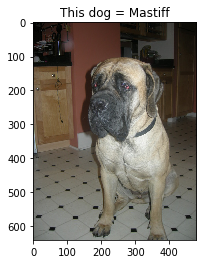

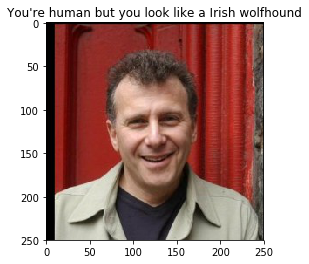

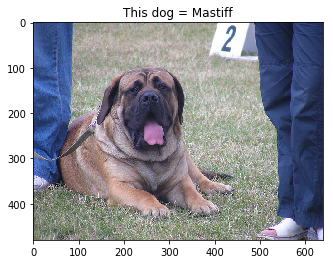

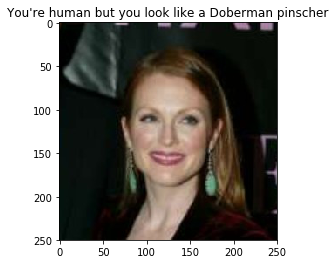

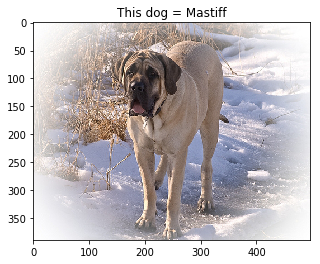

In [51]:
n2 = [1,10,20,30,50]

for n in n2:
    for file in np.hstack((human_files[n], dog_files[n])):
        run_app(file)

In [49]:
np.hstack((human_files[:4], dog_files[:4]))

array(['/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg',
       '/data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg',
       '/data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg',
       '/data/lfw/Donald_Carty/Donald_Carty_0001.jpg',
       '/data/dog_images/train/103.Mastiff/Mastiff_06833.jpg',
       '/data/dog_images/train/103.Mastiff/Mastiff_06826.jpg',
       '/data/dog_images/train/103.Mastiff/Mastiff_06871.jpg',
       '/data/dog_images/train/103.Mastiff/Mastiff_06812.jpg'], 
      dtype='<U106')

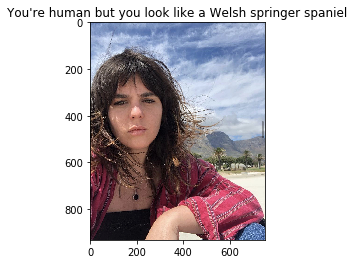

In [57]:
run_app('/home/workspace/dog_project/images/IMG_4978.jpg')

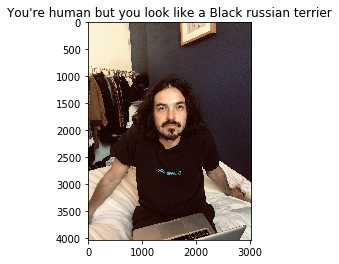

In [59]:
run_app('/home/workspace/dog_project/images/IMG_4979.jpg')